The global box office revenue in 2019 was over 42 billion dollars according to statista.com, and will continue to grow. Production companies may invest hundreds of millions of dollars in a single movie, hoping it will be the next box office success. The goal of this project is to predict the lifetime adjusted gross of domestic box office movies using a number of features defined for every movie. The data was obtained using Beautiful Soup from both boxofficemojo.com and imdb.com. The data was scrubbed by converting categorical columns to binary columns using multilabelbinarizer() and binning. The data was explored with self built plotting function using seaborn data visualization. The data was modeled using several supervised learning regressors. The data was interpreted using various scoring techniques and feature importance graphing. 

The best performing model was built by GradientBoostingRegressor() using grid search cross validation and a hyperparameter grid - the mean absolute percent error of the model was 31%. The feature importance graph of this model showed that franchise was an important feature in correctly predicting the target. In response, more franchise related predictors were added to the model in the form of a binary matrix, resulting in an improvement of the model. The final model was able to predict the lifetime adjusted gross of a movie, on average, with an error of +/- 30%. 

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import difflib
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import  f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
import itertools
                                                                


### Create reusable plotting functions for use during exploratory data analysis

In [3]:
def bar_graph_function(x_list, y_list, title_title, \
                       xlabel_title, ylabel_title):
    """This function will create a bar plot with 5 inputs: 
    x axis data, y axis data, plot title, x axis label, 
    y axis label"""
    plt.figure(figsize=(10,8))
    sns.barplot(x = x_list, y = y_list, palette = 'husl')
    plt.title(title_title, fontsize = 18)
    plt.xticks(rotation = 45, fontsize = 14, \
               horizontalalignment="right")
    plt.xlabel(xlabel_title, fontsize = 18)
    plt.yticks(fontsize = 14)
    plt.ylabel(ylabel_title, fontsize = 18)
    plt.tight_layout()

In [4]:
def scatter_function(x_list, y_list, title_title, xlabel_title, ylabel_title):
    """This function will create a bar plot with 5 inputs: 
    x axis data, y axis data, plot title, x axis label, y axis label"""
    plt.figure(figsize=(10,8))
    sns.scatterplot(x = x_list, y = y_list, color = 'orchid', s = 70)
    plt.title(title_title, fontsize = 18)
    plt.xticks(rotation = 45, fontsize = 14, horizontalalignment="right")
    plt.xlabel(xlabel_title, fontsize = 18)
    plt.yticks(fontsize = 14)
    plt.ylabel(ylabel_title, fontsize = 18)
    plt.tight_layout()
    

In [5]:
def single_boxplot_function(boxplot_data, xlabel_title):
    """This function will create a single boxplot with 2 inputs: data and x axis label"""
    plt.figure(figsize=(12,6))
    sns.boxplot(boxplot_data, palette = 'husl')
    plt.xticks(fontsize = 14)
    plt.xlabel(xlabel_title, fontsize = 18)
    plt.tight_layout()

### Open and convert data scraped from Box Office Mojo's 'Top 1000  Domestic Lifetime Adjusted Gross' to a dataframe. This data includes movie name, movie id (assigned by IMDB), adjusted lifetime gross, lifetime gross, estimated number of tickets sold, mpaa rating (if available), run time, earliest domestic release date, the production company, the genre (can overlap), top 4 cast members, and lists of crew members, including: directors, writers, producers, composers, cinematographers, production designers, and editors. Not all movies include all 7 types of crew members, and each movie may contain a different number of each type of crew member. 

In [6]:
with open("mojo_cumulative_scraper_w_id.txt","r") as f:
    everything_but_franchise = f.read()

# decoding the JSON to dictionay
guru_summary_cast_crew = json.loads(everything_but_franchise)
guru_summary_cast_crew_df = pd.DataFrame.from_dict(guru_summary_cast_crew)
guru_summary_cast_crew_df.columns = map(str.lower, guru_summary_cast_crew_df.head().columns)
guru_summary_cast_crew_df = guru_summary_cast_crew_df \
    .rename(columns = {'production designer': 'prod_designer'})


guru_summary_cast_crew_df = guru_summary_cast_crew_df[['movie_name', 'movie_id', \
                            'adj_lifetime_gross', 'lifetime_gross', 'est_num_tickets', \
                            'mpaa_rating', 'running_time', 'earliest_dom_release_date', \
                            'production_companies', 'movie_genre', 'cast', 'director', \
                            'writer', 'producer', 'composer', 'cinematographer', \
                            'prod_designer', 'editor' ]]
                                                     
for col in guru_summary_cast_crew_df.columns[0:11]:
    guru_summary_cast_crew_df[col] = guru_summary_cast_crew_df[col].str[0]

guru_summary_cast_crew_df[guru_summary_cast_crew_df.columns[2:5]] = \
    guru_summary_cast_crew_df[guru_summary_cast_crew_df.columns[2:5]]\
    .replace('[\$,]', '', regex=True).astype(float)
guru_summary_cast_crew_df['earliest_dom_release_date'] = pd.to_datetime \
    (guru_summary_cast_crew_df['earliest_dom_release_date'])

guru_summary_cast_crew_df.head()


,movie_name,movie_id,adj_lifetime_gross,lifetime_gross,est_num_tickets,mpaa_rating,running_time,earliest_dom_release_date,production_companies,movie_genre,cast,director,writer,producer,composer,cinematographer,prod_designer,editor
0,Gone with the Wind (1939),tt0031381,1.895422e+09,200852579.0,202286200.0,NaN,3 hr 58 min,1939-12-15,Metro-Goldwyn-Mayer (MGM),"[Drama, History, Romance, War]","[Clark Gable, Vivien Leigh, Thomas Mitchell, B...","[Victor Fleming, George Cukor, Sam Wood]","[Margaret Mitchell, Sidney Howard, Oliver H.P....",[David O. Selznick],[Max Steiner],[Ernest Haller],[William Cameron Menzies],NaN
1,Star Wars: Episode IV - A New Hope (1977),tt0076759,1.668980e+09,460998507.0,178119500.0,PG,2 hr 1 min,1977-05-25,Twentieth Century Fox,"[Action, Adventure, Fantasy, Sci-Fi]","[Mark Hamill, Harrison Ford, Carrie Fisher, Al...",[George Lucas],[George Lucas],"[Gary Kurtz, Rick McCallum]",[John Williams],[Gilbert Taylor],[John Barry],"[Richard Chew, T.M. Christopher, Paul Hirsch, ..."
2,The Sound of Music (1965),tt0059742,1.335086e+09,159287539.0,142485200.0,NaN,2 hr 52 min,1965-03-02,Twentieth Century Fox,"[Biography, Drama, Family, Musical, Romance]","[Julie Andrews, Christopher Plummer, Eleanor P...",[Robert Wise],"[George Hurdalek, Howard Lindsay, Russel Crous...",[Robert Wise],NaN,[Ted D. McCord],[Boris Leven],[William Reynolds]
3,E.T. the Extra-Terrestrial (1982),tt0083866,1.329175e+09,435110554.0,141854300.0,PG,1 hr 55 min,1982-06-11,Universal Pictures,"[Family, Sci-Fi]","[Henry Thomas, Drew Barrymore, Peter Coyote, D...",[Steven Spielberg],[Melissa Mathison],"[Kathleen Kennedy, Steven Spielberg]",[John Williams],[Allen Daviau],[Jim Bissell],[Carol Littleton]
4,Titanic (1997),tt0120338,1.270102e+09,659363944.0,135549800.0,PG-13,3 hr 14 min,1997-12-18,Paramount Pictures,"[Drama, Romance]","[Leonardo DiCaprio, Kate Winslet, Billy Zane, ...",[James Cameron],[James Cameron],"[James Cameron, Jon Landau]",[James Horner],[Russell Carpenter],[Peter Lamont],"[Conrad Buff IV, James Cameron, Richard A. Har..."


In [7]:
guru_summary_cast_crew_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
movie_name                   1000 non-null object
movie_id                     1000 non-null object
adj_lifetime_gross           1000 non-null float64
lifetime_gross               1000 non-null float64
est_num_tickets              1000 non-null float64
mpaa_rating                  713 non-null object
running_time                 1000 non-null object
earliest_dom_release_date    1000 non-null datetime64[ns]
production_companies         1000 non-null object
movie_genre                  1000 non-null object
cast                         1000 non-null object
director                     1000 non-null object
writer                       1000 non-null object
producer                     982 non-null object
composer                     944 non-null object
cinematographer              928 non-null object
prod_designer                904 non-null object
editor                       992 non-n

In [8]:
guru_summary_cast_crew_df.fillna('None', inplace = True)
guru_summary_cast_crew_df.loc[guru_summary_cast_crew_df \
    ['production_companies'] == '', 'production_companies'] = 'None' 
guru_summary_cast_crew_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
movie_name                   1000 non-null object
movie_id                     1000 non-null object
adj_lifetime_gross           1000 non-null float64
lifetime_gross               1000 non-null float64
est_num_tickets              1000 non-null float64
mpaa_rating                  1000 non-null object
running_time                 1000 non-null object
earliest_dom_release_date    1000 non-null datetime64[ns]
production_companies         1000 non-null object
movie_genre                  1000 non-null object
cast                         1000 non-null object
director                     1000 non-null object
writer                       1000 non-null object
producer                     1000 non-null object
composer                     1000 non-null object
cinematographer              1000 non-null object
prod_designer                1000 non-null object
editor                       1000

### Open and convert movie budget data scraped from IMDB to a dataframe. This data includes movie id (assigned by IMDB) and a non adjusted budget (sometimes estimated). Not all 1000 movies from the first scrape had official, or estimated budgets, listed on IMDB (missing 42/1000). This budget data is then joined onto the original dataframe using the 'movie_id' column. 

In [9]:
with open("budget_list.txt","r") as f:
    budget_list = f.read()

budget_list = json.loads(budget_list)
budget_df = pd.DataFrame(budget_list)

budget_df.columns = ['movie_id', 'budget_non_adj'] 
budget_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 2 columns):
movie_id          958 non-null object
budget_non_adj    958 non-null object
dtypes: object(2)
memory usage: 15.1+ KB


In [10]:
guru_summary_cast_crew_df = guru_summary_cast_crew_df \
    .join(budget_df.set_index('movie_id'), on = 'movie_id')
guru_summary_cast_crew_df.drop('movie_id', axis = 1, inplace = True)
guru_summary_cast_crew_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
movie_name                   1000 non-null object
adj_lifetime_gross           1000 non-null float64
lifetime_gross               1000 non-null float64
est_num_tickets              1000 non-null float64
mpaa_rating                  1000 non-null object
running_time                 1000 non-null object
earliest_dom_release_date    1000 non-null datetime64[ns]
production_companies         1000 non-null object
movie_genre                  1000 non-null object
cast                         1000 non-null object
director                     1000 non-null object
writer                       1000 non-null object
producer                     1000 non-null object
composer                     1000 non-null object
cinematographer              1000 non-null object
prod_designer                1000 non-null object
editor                       1000 non-null object
budget_non_adj               958 

### The return on investment (percentage) is the calculated for all movies with a listed budget. The lifetime gross (non adjusted) is then divided by the budget (non adjusted), minus 1, and time 100 to calculate the return on investment (percentage) for each movie. The median return on investment is then used to fill the missing budget for 42 movies.

In [11]:
movies_with_budget = guru_summary_cast_crew_df.copy()

movies_with_budget = movies_with_budget.fillna('None')

movies_with_budget = movies_with_budget.loc[movies_with_budget['budget_non_adj'] != 'None']
movies_with_budget['budget_non_adj'] = pd.to_numeric(movies_with_budget['budget_non_adj'])

movies_with_budget['return_on_investment'] = \
    ((movies_with_budget['lifetime_gross'] / movies_with_budget['budget_non_adj']) - 1)*100

print(movies_with_budget['return_on_investment'].median())


159.54084555555556


In [12]:
budget_pred_denom = (movies_with_budget['return_on_investment'].median()/100)+1
repeat_loc = guru_summary_cast_crew_df['budget_non_adj'].isna()

guru_summary_cast_crew_df.loc[repeat_loc, 'budget_non_adj'] = guru_summary_cast_crew_df \
    .loc[repeat_loc, 'lifetime_gross']/budget_pred_denom
guru_summary_cast_crew_df['budget_non_adj'] = pd \
    .to_numeric(guru_summary_cast_crew_df['budget_non_adj'])


### Cast and crew columns are now converted to binary columns by splitting each column into either 'A list' and 'B list'.  An 'A list' member means that that member appears in more than 1 movie within the dataframe. If the movie contains at least one 'A list' member, then that movie will have a 'True' 'A list' member column. If the movie does not contain at least one 'A list' member, then that movie will have a 'True' 'B list' member column. This is completed individually for cast, directors, writers, producers, composers, cinematographers, production designers, and editors. The number of A list and B list members is printed and plotted, and the top members by appearance is also plotted. 

In [13]:
def a_b_list_cc_splitter(orig_col_name, new_col_name, cut_off_count):
    """Convert cast and crew columns into a_list (1.0 or 0.0) if the member appears in 
        more than one movie. Plot number of A list versus B list, and plot 
        top members by movie appearance count"""
    
    a_b_list_df = guru_summary_cast_crew_df \
        [[orig_col_name, 'movie_name', 'adj_lifetime_gross']].copy()
    a_b_list_df = a_b_list_df.explode(orig_col_name)
    
    a_b_list = (pd.DataFrame(a_b_list_df.groupby([orig_col_name]) \
        [orig_col_name].count().sort_values(ascending = False)))
    a_b_list.rename(columns = {orig_col_name : 'movie_count'}, inplace = True)
    print("Unique Members: ", a_b_list.size)
    alist = a_b_list.loc[a_b_list['movie_count'] > 1]
    print("A list (>1): ", alist.size)
    blist = a_b_list.loc[a_b_list['movie_count'] == 1]
    print("B list (=1): ", blist.size)
    
    alist.reset_index(inplace = True)
    alist_list = list(alist[orig_col_name])
    if 'None' in alist_list: alist_list.remove('None')
    guru_summary_cast_crew_df.head()

    
    for i in range(len(guru_summary_cast_crew_df)): 
        full_list = guru_summary_cast_crew_df.loc[i, orig_col_name]
        guru_summary_cast_crew_df.loc[i, new_col_name] = \
            bool(set(alist_list) & set(full_list))*1
        
    member_breakdown = [alist.size, blist.size]
    x_labels = ['Worked in 2+ Movies', 'Worked in only 1 Movie']

    bar_graph_function(x_labels, member_breakdown, \
                       'Number of A vs B List ' + str(orig_col_name).capitalize(),\
                       '', 'Member Count')
    
    a_b_list.reset_index(inplace = True)
    a_b_list_cut_off = a_b_list.loc[a_b_list['movie_count']>cut_off_count]
    a_b_list_cut_off = a_b_list_cut_off[a_b_list_cut_off[orig_col_name] != 'None']
    bar_graph_function(a_b_list_cut_off[orig_col_name], a_b_list_cut_off['movie_count'],\
                       'Top ' + str(orig_col_name).capitalize() + ' by Appearances', \
                       '', 'Movie Count')



Unique Members:  1953
A list (>1):  718
B list (=1):  1235


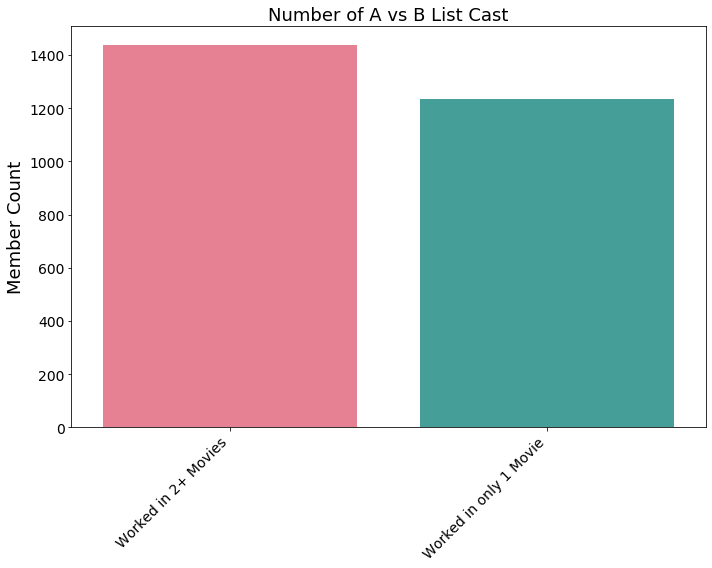

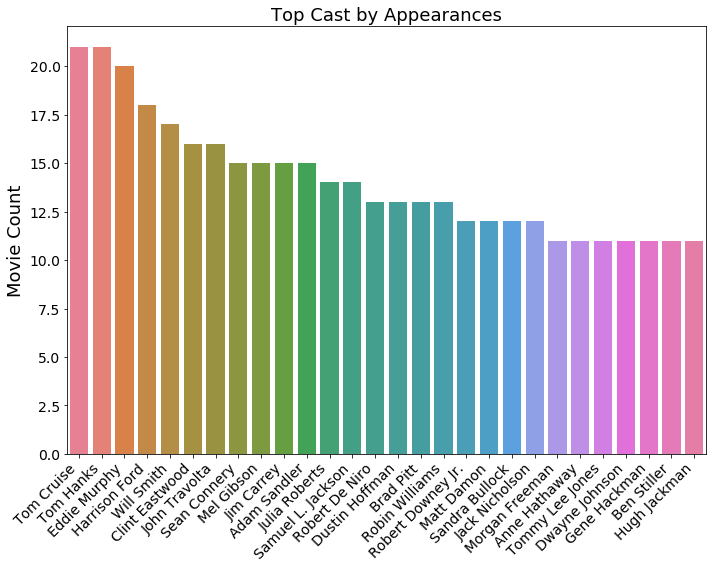

In [14]:
a_b_list_cc_splitter('cast', 'a_list_cast', 10)


Unique Members:  569
A list (>1):  260
B list (=1):  309


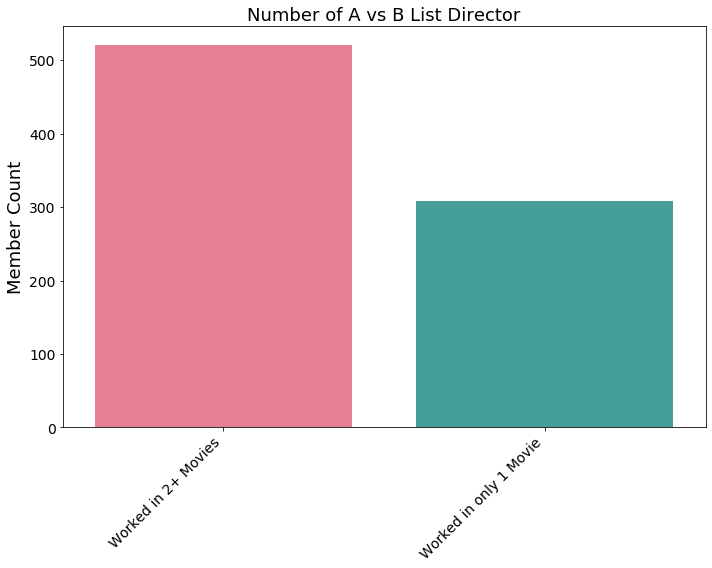

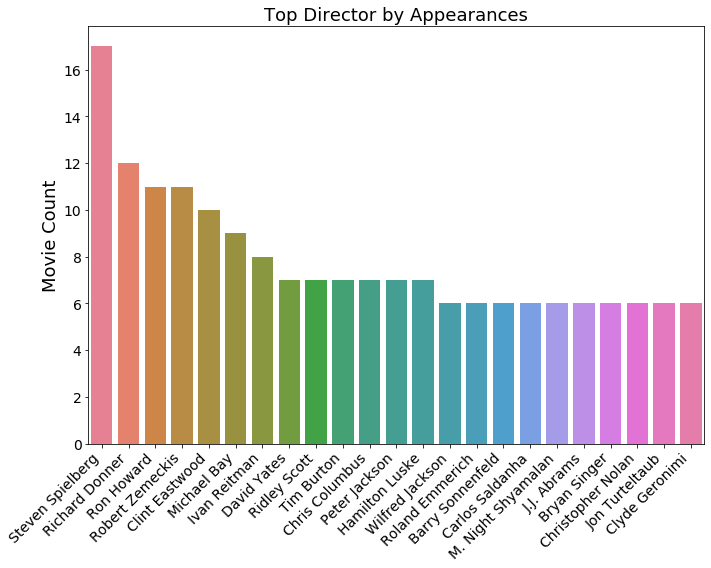

In [15]:
a_b_list_cc_splitter('director', 'a_list_director', 5)


Unique Members:  1859
A list (>1):  802
B list (=1):  1057


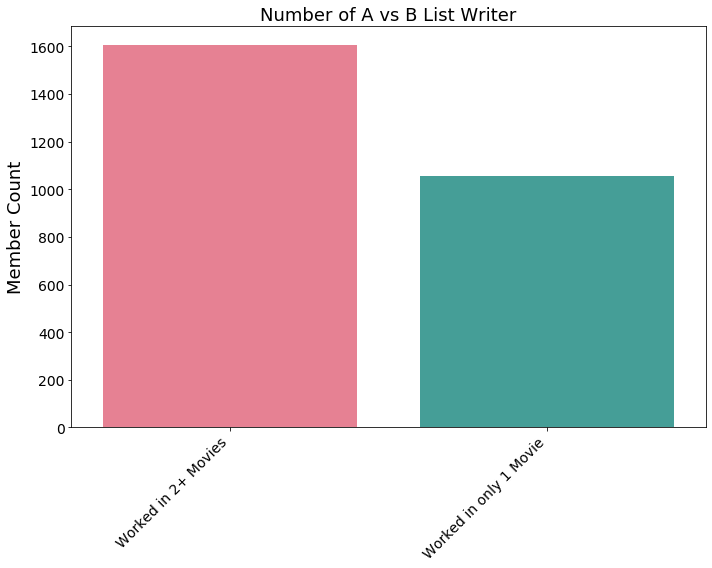

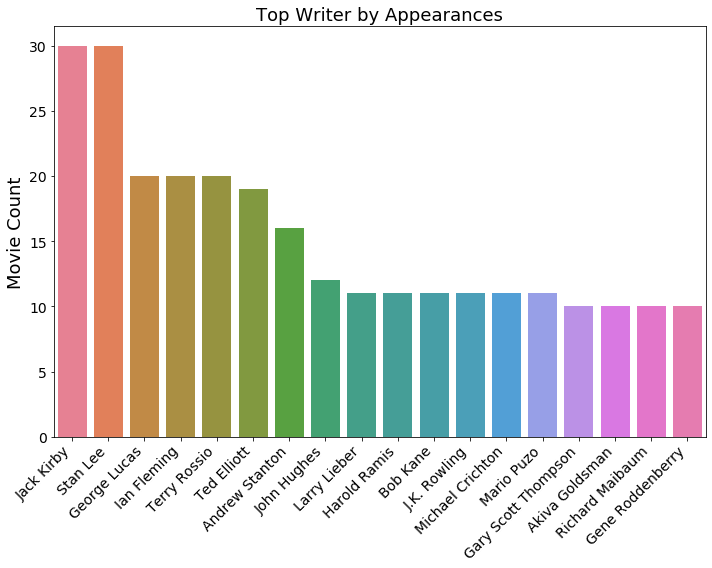

In [16]:
a_b_list_cc_splitter('writer', 'a_list_writer', 9)


Unique Members:  969
A list (>1):  401
B list (=1):  568


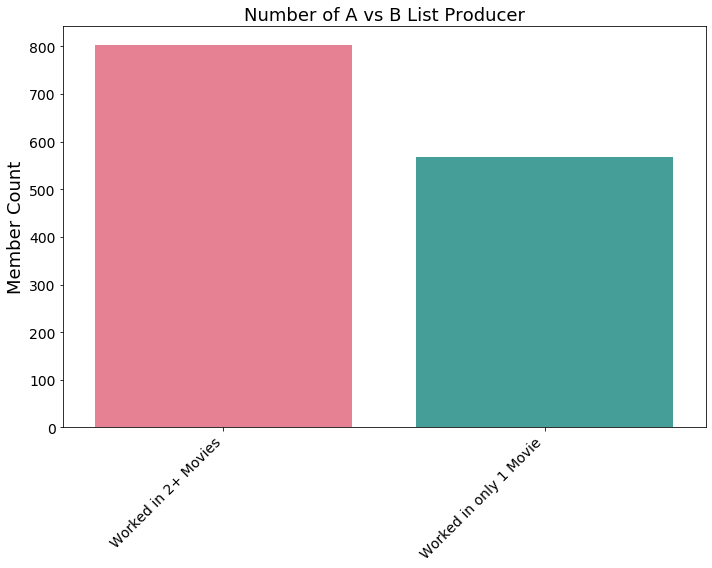

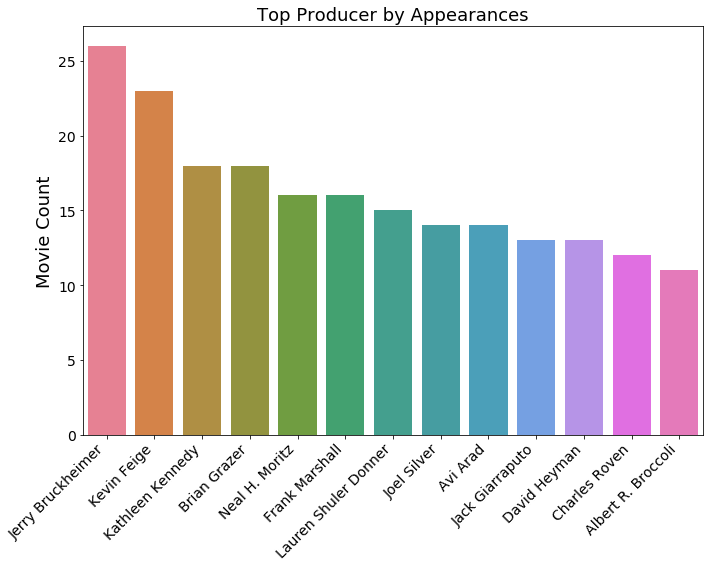

In [17]:
a_b_list_cc_splitter('producer', 'a_list_producer', 10)


Unique Members:  314
A list (>1):  129
B list (=1):  185


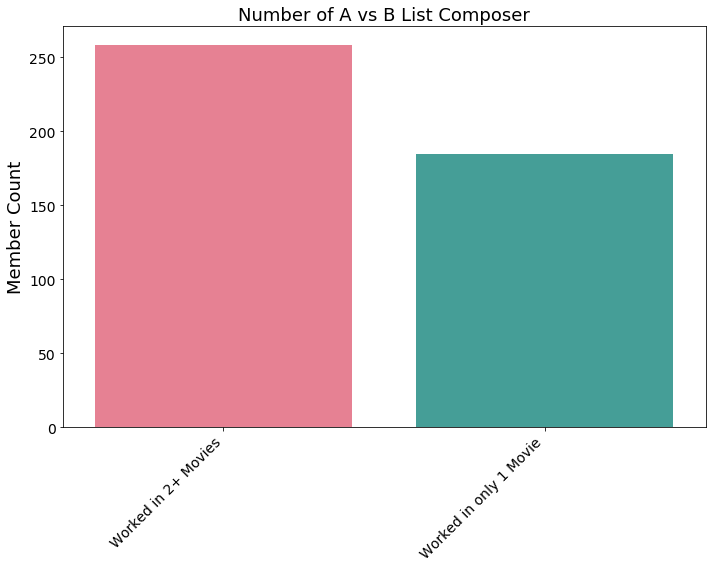

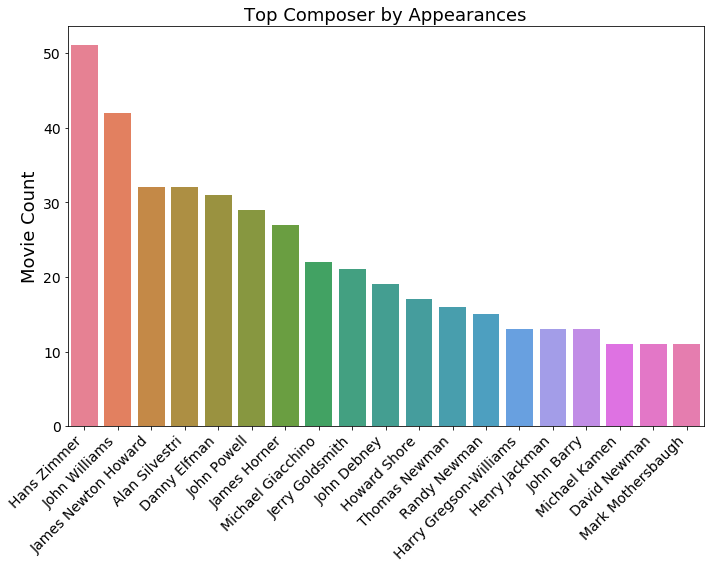

In [18]:
a_b_list_cc_splitter('composer', 'a_list_composer', 10)


Unique Members:  366
A list (>1):  186
B list (=1):  180


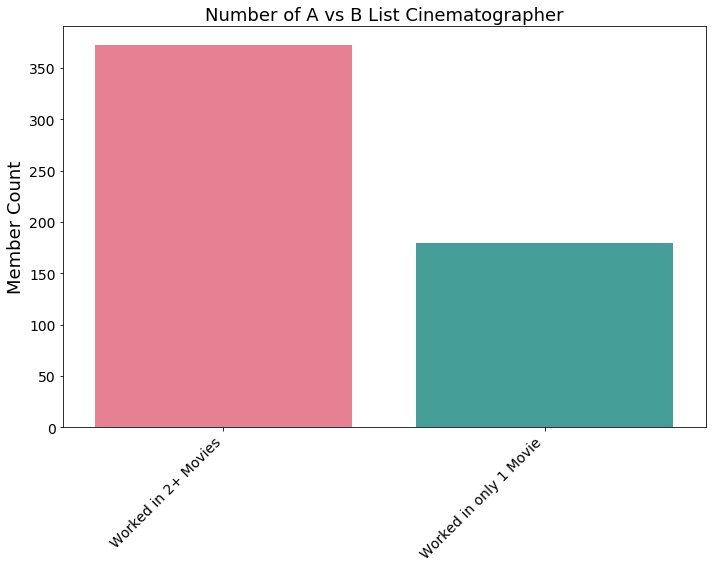

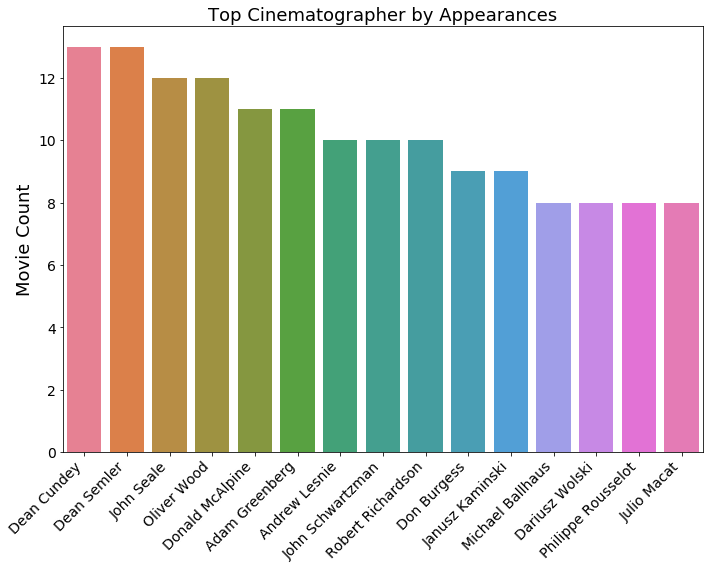

In [19]:
a_b_list_cc_splitter('cinematographer', 'a_list_cinematographer', 7)


Unique Members:  379
A list (>1):  196
B list (=1):  183


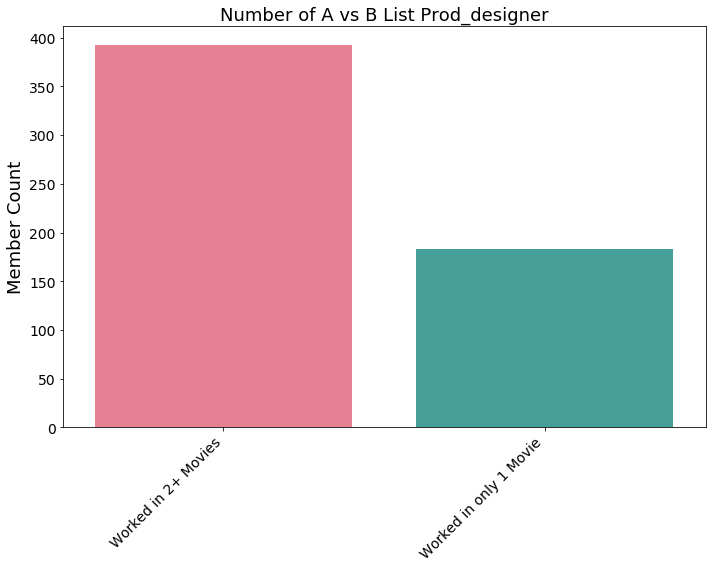

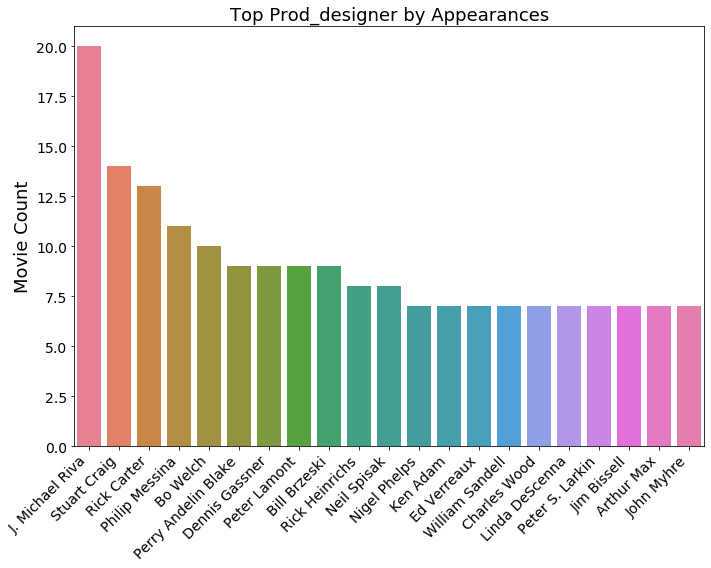

In [20]:
a_b_list_cc_splitter('prod_designer', 'a_list_prod_designer', 6)


Unique Members:  559
A list (>1):  299
B list (=1):  260


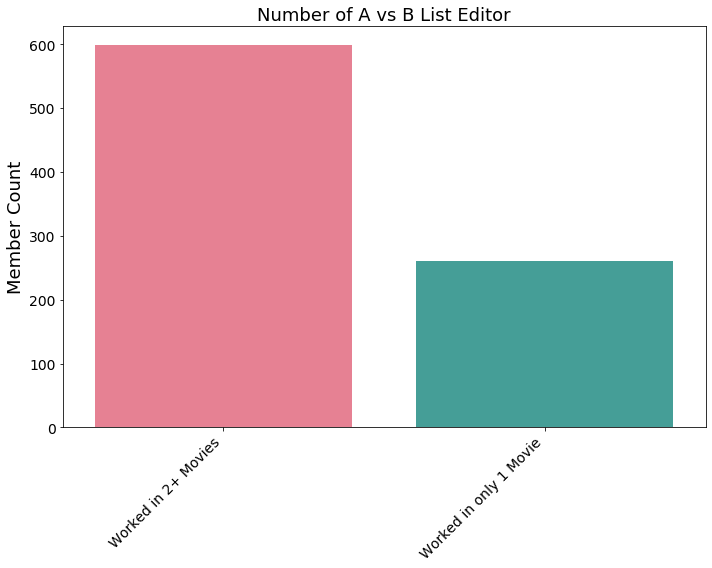

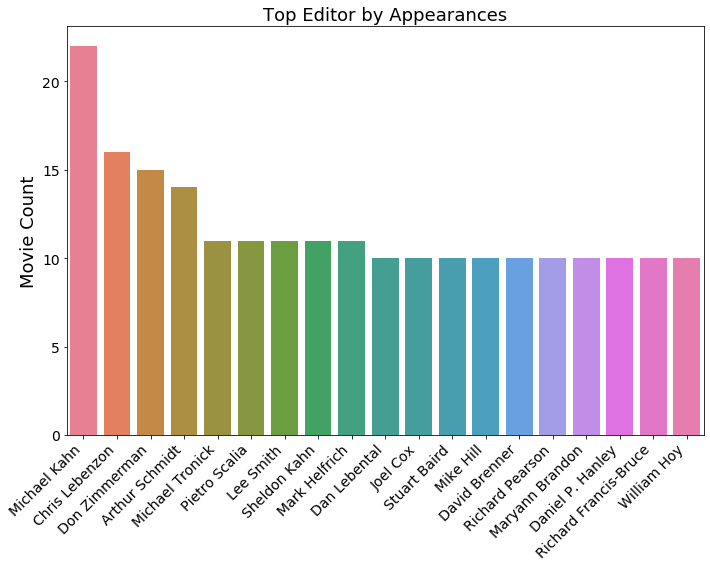

In [21]:
a_b_list_cc_splitter('editor', 'a_list_editor', 9)


### Open and convert movie franchise data scraped from boxofficemojo to a dataframe. This data includes the movie name and franchise information for all franchises listed within boxoffice mojo (not just the top 1000 adjusted domestic movies). This franchise data is the joined onto the latest dataframe using the movie name (not including data) columns. Approximately 43% of the movies are part of a franchise.


In [22]:
with open("BOM_movie_franchise_with_date_list.txt","r") as f:
    movie_franchise_with_date = f.read()

movie_franchise_with_date = json.loads(movie_franchise_with_date)
movie_franchise_with_date_df = pd.DataFrame(movie_franchise_with_date)

movie_franchise_with_date_df = pd.DataFrame(movie_franchise_with_date, \
    columns = ['franchise', 'movie_name_no_year', 'movie_year']).copy()
movie_franchise_with_date_df['franchise'] = movie_franchise_with_date_df['franchise'] \
    .str[11:].copy()
movie_franchise_with_date_df.drop('movie_year', axis = 1, inplace = True)

movie_franchise_with_date_df = movie_franchise_with_date_df \
    .drop_duplicates('movie_name_no_year', keep='last')

movie_franchise_with_date_df.set_index('movie_name_no_year', inplace = True)
movie_franchise_with_date_df

,franchise
movie_name_no_year,
Black Panther,Marvel Cinematic Universe
Captain Marvel,Marvel Cinematic Universe
The Incredible Hulk,Marvel Cinematic Universe
Untitled Marvel (Feb 2023),Marvel Cinematic Universe
Untitled Marvel (May 2023),Marvel Cinematic Universe
...,...
Evangelion: 2.0 You Can (Not) Advance,Evangelion
Evangelion: 1.0 You Are (Not) Alone,Evangelion
V/H/S,V/H/S


In [23]:
guru_summary_cast_crew_df['movie_name_no_year'] = guru_summary_cast_crew_df['movie_name']\
    .str[:-7]
guru_summary_cast_crew_df.set_index('movie_name_no_year', inplace = True)

guru_summary_cast_crew_df

,movie_name,adj_lifetime_gross,lifetime_gross,est_num_tickets,mpaa_rating,running_time,earliest_dom_release_date,production_companies,movie_genre,cast,...,editor,budget_non_adj,a_list_cast,a_list_director,a_list_writer,a_list_producer,a_list_composer,a_list_cinematographer,a_list_prod_designer,a_list_editor
movie_name_no_year,,,,,,,,,,,,,,,,,,,,,
Gone with the Wind,Gone with the Wind (1939),1.895422e+09,200852579.0,202286200.0,None,3 hr 58 min,1939-12-15,Metro-Goldwyn-Mayer (MGM),"[Drama, History, Romance, War]","[Clark Gable, Vivien Leigh, Thomas Mitchell, B...",...,None,3.977000e+06,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
Star Wars: Episode IV - A New Hope,Star Wars: Episode IV - A New Hope (1977),1.668980e+09,460998507.0,178119500.0,PG,2 hr 1 min,1977-05-25,Twentieth Century Fox,"[Action, Adventure, Fantasy, Sci-Fi]","[Mark Hamill, Harrison Ford, Carrie Fisher, Al...",...,"[Richard Chew, T.M. Christopher, Paul Hirsch, ...",1.100000e+07,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
The Sound of Music,The Sound of Music (1965),1.335086e+09,159287539.0,142485200.0,None,2 hr 52 min,1965-03-02,Twentieth Century Fox,"[Biography, Drama, Family, Musical, Romance]","[Julie Andrews, Christopher Plummer, Eleanor P...",...,[William Reynolds],8.200000e+06,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
E.T. the Extra-Terrestrial,E.T. the Extra-Terrestrial (1982),1.329175e+09,435110554.0,141854300.0,PG,1 hr 55 min,1982-06-11,Universal Pictures,"[Family, Sci-Fi]","[Henry Thomas, Drew Barrymore, Peter Coyote, D...",...,[Carol Littleton],1.050000e+07,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Titanic,Titanic (1997),1.270102e+09,659363944.0,135549800.0,PG-13,3 hr 14 min,1997-12-18,Paramount Pictures,"[Drama, Romance]","[Leonardo DiCaprio, Kate Winslet, Billy Zane, ...",...,"[Conrad Buff IV, James Cameron, Richard A. Har...",2.000000e+08,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Murder on the Orient Express,Murder on the Orient Express (1974),1.384689e+08,27634716.0,14777900.0,None,2 hr 8 min,1974-11-24,Paramount Pictures,"[Crime, Drama, Mystery]","[Albert Finney, Lauren Bacall, Ingrid Bergman,...",...,[Anne V. Coates],1.064754e+07,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
Spy Kids 2: Island of Lost Dreams,Spy Kids 2: Island of Lost Dreams (2002),1.384389e+08,85846429.0,14774700.0,PG,1 hr 40 min,2002-08-07,Dimension Films,"[Action, Adventure, Comedy, Family, Sci-Fi]","[Alexa PenaVega, Daryl Sabara, Antonio Bandera...",...,[Robert Rodriguez],3.800000e+07,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Mystic River,Mystic River (2003),1.383986e+08,90135191.0,14770400.0,R,2 hr 18 min,2003-10-08,Warner Bros.,"[Crime, Drama, Mystery, Thriller]","[Sean Penn, Tim Robbins, Kevin Bacon, Emmy Ros...",...,[Joel Cox],2.500000e+07,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [24]:
movie_df = guru_summary_cast_crew_df.join(movie_franchise_with_date_df)
movie_df.franchise.fillna('None', inplace=True)
movie_df.reset_index(inplace = True)
movie_df



,movie_name_no_year,movie_name,adj_lifetime_gross,lifetime_gross,est_num_tickets,mpaa_rating,running_time,earliest_dom_release_date,production_companies,movie_genre,...,budget_non_adj,a_list_cast,a_list_director,a_list_writer,a_list_producer,a_list_composer,a_list_cinematographer,a_list_prod_designer,a_list_editor,franchise
0,10,10 (1979),279478053.0,74865517.0,29826900.0,None,2 hr 2 min,1979-10-05,Warner Bros.,"[Comedy, Romance]",...,2.884537e+07,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,None
1,101 Dalmatians,101 Dalmatians (1996),285296823.0,136189294.0,30447900.0,None,1 hr 43 min,1996-11-27,Walt Disney Studios Motion Pictures,"[Adventure, Comedy, Crime, Family]",...,7.500000e+07,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,Disney Live Action Reimaginings
2,1917,1917 (2019),159227221.0,159227644.0,16993300.0,R,1 hr 59 min,2019-12-25,Universal Pictures,"[Drama, War]",...,9.500000e+07,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,None
3,2 Fast 2 Furious,2 Fast 2 Furious (2003),197585190.0,127154901.0,21087000.0,PG-13,1 hr 47 min,2003-06-05,Universal Pictures,"[Action, Crime, Thriller]",...,7.600000e+07,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,The Fast and the Furious
4,2001: A Space Odyssey,2001: A Space Odyssey (1968),409839115.0,60541301.0,43739500.0,None,2 hr 29 min,1968-04-03,Metro-Goldwyn-Mayer (MGM),"[Adventure, Sci-Fi]",...,1.200000e+07,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,You Only Live Twice,You Only Live Twice (1967),336420480.0,43084787.0,35904000.0,PG,1 hr 57 min,1967-06-13,United Artists,"[Action, Adventure, Thriller]",...,9.500000e+06,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,James Bond
996,You've Got Mail,You've Got Mail (1998),223410784.0,115821495.0,23843200.0,PG,1 hr 59 min,1998-12-18,Warner Bros.,"[Comedy, Drama, Romance]",...,6.500000e+07,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,None
997,Young Frankenstein,Young Frankenstein (1974),427715201.0,86273333.0,45647300.0,None,1 hr 46 min,1974-12-15,Twentieth Century Fox,[Comedy],...,2.800000e+06,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,None
998,Zootopia,Zootopia (2016),371109157.0,341268248.0,39606100.0,PG,1 hr 48 min,2016-02-10,Walt Disney Studios Motion Pictures,"[Adventure, Animation, Comedy, Crime, Family, ...",...,1.500000e+08,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,None


### convert genres to a binary matrix using multilabelbinarizer, and rejoin to orginal dataframe. VIsualize genres by movie count.

In [25]:
mlb = MultiLabelBinarizer()
genres_series_df = movie_df[['movie_name','movie_genre']]
genres_series_df.set_index('movie_name', inplace = True)


genres_series = genres_series_df['movie_genre']

genres_ohe = pd.DataFrame(mlb.fit_transform(genres_series),
                   columns=mlb.classes_,
                   index=genres_series.index)


genres_ohe.head()

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
movie_name,,,,,,,,,,,,,,,,,,,,,
10 (1979),0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
101 Dalmatians (1996),0,1,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1917 (2019),0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2 Fast 2 Furious (2003),1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2001: A Space Odyssey (1968),0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [26]:
movie_df.set_index('movie_name', inplace = True)
movie_df = movie_df.join(genres_ohe)
movie_df.reset_index(inplace = True)

movie_df.columns = map(str.lower, movie_df.head().columns)


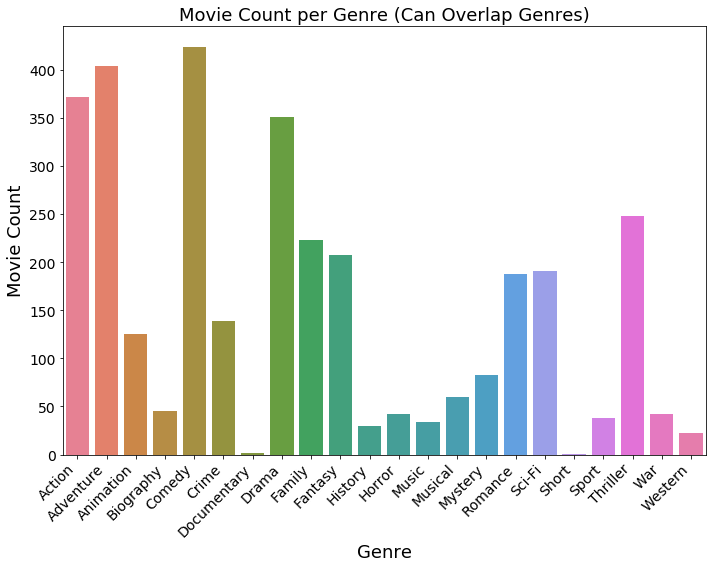

In [27]:
genres_ohe.head()
genre_count = list(genres_ohe.sum())
genre_list = list(genres_ohe.columns.values)

bar_graph_function(genre_list, genre_count, 'Movie Count per Genre (Can Overlap Genres)', \
                    'Genre', 'Movie Count')

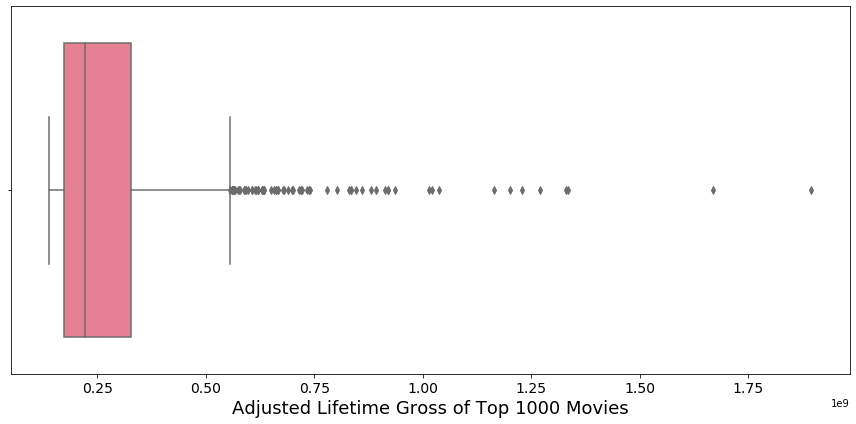

In [28]:
single_boxplot_function(movie_df['adj_lifetime_gross'], \
                        'Adjusted Lifetime Gross of Top 1000 Movies')

### explore the franchise categorical data by plotting the top franchises by movie count, total adjusted gross and average adjusted gross

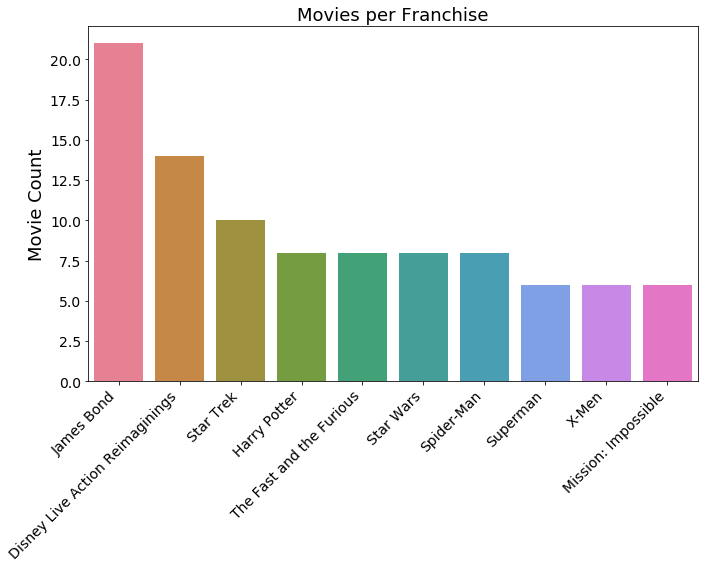

In [29]:
franchise_df = movie_df.loc[movie_df['franchise'] != 'None']
no_franchise_df = movie_df.loc[movie_df['franchise'] == 'None']

movie_df.loc[movie_df['franchise'] != 'None', 'franchise_y_n'] = 1
movie_df.loc[movie_df['franchise'] == 'None', 'franchise_y_n'] = 0


franchise_count = franchise_df['franchise']
franchise_count = franchise_count.value_counts()

franchise_count_df = pd.DataFrame(franchise_count)
franchise_count_df = franchise_count_df.loc[(franchise_count_df['franchise']) >= 6]
franchise_count_df.reset_index(inplace = True)
franchise_count_df.rename(columns = {'index': 'franchise', 'franchise':'movie_count'}, \
                          inplace = True)

bar_graph_function(franchise_count_df['franchise'], \
                   franchise_count_df['movie_count'], \
                   'Movies per Franchise', '', 'Movie Count')

plt.savefig('images/movie_count_per_franchise.png')

434
566


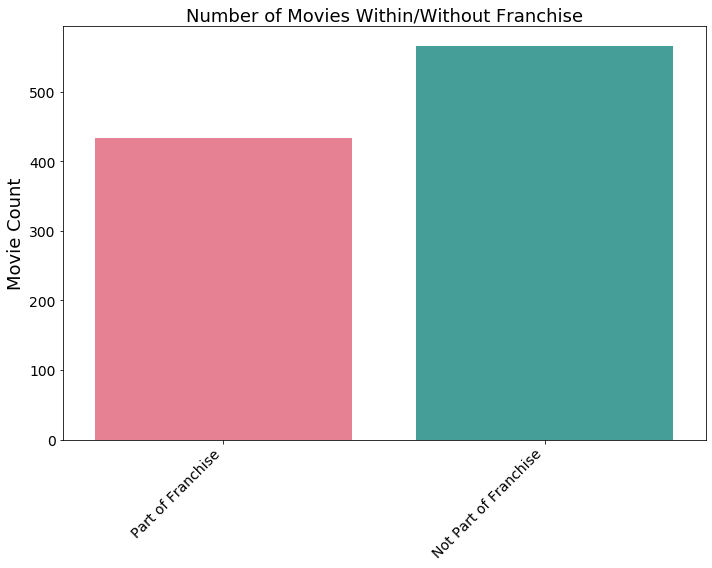

In [30]:
franchise_df.reset_index(inplace = True)
no_franchise_df.reset_index(inplace = True)

yes_or_no_franchise_y = []
yes_or_no_franchise_x = ['Part of Franchise', 'Not Part of Franchise']
yes_or_no_franchise_y.append(franchise_df['movie_name'].count())
yes_or_no_franchise_y.append(no_franchise_df['movie_name'].count())

bar_graph_function(yes_or_no_franchise_x, yes_or_no_franchise_y, \
                   'Number of Movies Within/Without Franchise', '', 'Movie Count')

print(franchise_df['movie_name'].count())
print(no_franchise_df['movie_name'].count())

plt.savefig('images/movies_within_without_franchise.png')

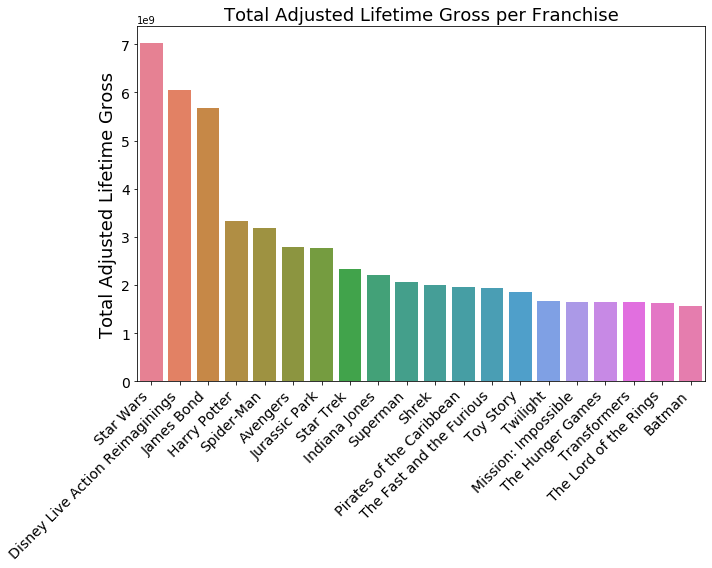

In [31]:
top_grossing_franchises = pd.DataFrame(franchise_df.groupby('franchise') \
    ['adj_lifetime_gross'].sum().sort_values(ascending = False)).head(20)
top_grossing_franchises.reset_index(inplace = True)
top_grossing_franchises

bar_graph_function(top_grossing_franchises['franchise'], \
    top_grossing_franchises['adj_lifetime_gross'], \
        'Total Adjusted Lifetime Gross per Franchise', '', 'Total Adjusted Lifetime Gross')

plt.savefig('images/top_grossing_franchise.png')

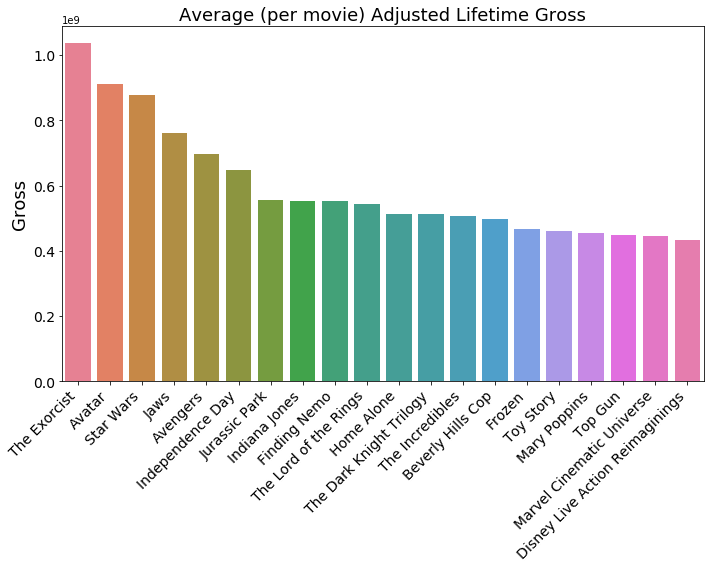

In [32]:
top_avg_grossing_franchises = pd.DataFrame(franchise_df.groupby('franchise') \
    ['adj_lifetime_gross'].mean().sort_values(ascending = False)).head(20)
top_avg_grossing_franchises.reset_index(inplace = True)

bar_graph_function(top_avg_grossing_franchises['franchise'], top_avg_grossing_franchises \
    ['adj_lifetime_gross'], 'Average (per movie) Adjusted Lifetime Gross', '', 'Gross')

plt.savefig('images/avg_grossing_franchise.png')

### explore MPAA rating by visualizing movie count by rating.  Convert the categorical column to binary matrx using multilabelbinarizer() and rejoin to original dataframe.

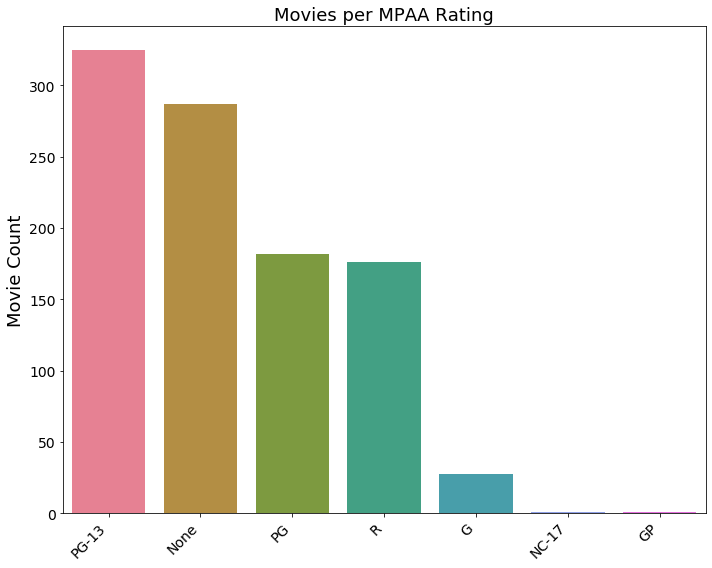

In [33]:
mpaa_rating_count = movie_df['mpaa_rating']
mpaa_rating_count = mpaa_rating_count.value_counts()
mpaa_rating_count_df = pd.DataFrame(mpaa_rating_count)
mpaa_rating_count_df.reset_index(inplace = True)
mpaa_rating_count_df.rename(columns = {'index': 'mpaa_rating', 'mpaa_rating':'movie_count'},\
    inplace = True)

bar_graph_function(mpaa_rating_count_df['mpaa_rating'], mpaa_rating_count_df['movie_count'], \
    'Movies per MPAA Rating', '', 'Movie Count')

plt.savefig('images/mpaa_rating.png')

In [34]:
mlb = MultiLabelBinarizer()
mpaa_rating_series_df = movie_df[['movie_name','mpaa_rating']]
mpaa_rating_ohe = pd.DataFrame(mlb.fit_transform(mpaa_rating_series_df['mpaa_rating'] \
    .fillna('missing').str.split(', ')),
                   columns=mlb.classes_,
                   index=mpaa_rating_series_df['movie_name'])

mpaa_rating_ohe.head()


,G,GP,NC-17,None,PG,PG-13,R
movie_name,,,,,,,
10 (1979),0,0,0,1,0,0,0
101 Dalmatians (1996),0,0,0,1,0,0,0
1917 (2019),0,0,0,0,0,0,1
2 Fast 2 Furious (2003),0,0,0,0,0,1,0
2001: A Space Odyssey (1968),0,0,0,1,0,0,0


In [35]:
movie_df.set_index(('movie_name'), inplace = True)
movie_df = movie_df.join(mpaa_rating_ohe)


In [36]:
movie_df

,movie_name_no_year,adj_lifetime_gross,lifetime_gross,est_num_tickets,mpaa_rating,running_time,earliest_dom_release_date,production_companies,movie_genre,cast,...,war,western,franchise_y_n,G,GP,NC-17,None,PG,PG-13,R
movie_name,,,,,,,,,,,,,,,,,,,,,
10 (1979),10,279478053.0,74865517.0,29826900.0,None,2 hr 2 min,1979-10-05,Warner Bros.,"[Comedy, Romance]","[Dudley Moore, Bo Derek, Julie Andrews, Robert...",...,0,0,0.0,0,0,0,1,0,0,0
101 Dalmatians (1996),101 Dalmatians,285296823.0,136189294.0,30447900.0,None,1 hr 43 min,1996-11-27,Walt Disney Studios Motion Pictures,"[Adventure, Comedy, Crime, Family]","[Glenn Close, Jeff Daniels, Joely Richardson, ...",...,0,0,1.0,0,0,0,1,0,0,0
1917 (2019),1917,159227221.0,159227644.0,16993300.0,R,1 hr 59 min,2019-12-25,Universal Pictures,"[Drama, War]","[Dean-Charles Chapman, George MacKay, Daniel M...",...,1,0,0.0,0,0,0,0,0,0,1
2 Fast 2 Furious (2003),2 Fast 2 Furious,197585190.0,127154901.0,21087000.0,PG-13,1 hr 47 min,2003-06-05,Universal Pictures,"[Action, Crime, Thriller]","[Paul Walker, Tyrese Gibson, Cole Hauser, Eva ...",...,0,0,1.0,0,0,0,0,0,1,0
2001: A Space Odyssey (1968),2001: A Space Odyssey,409839115.0,60541301.0,43739500.0,None,2 hr 29 min,1968-04-03,Metro-Goldwyn-Mayer (MGM),"[Adventure, Sci-Fi]","[Keir Dullea, Gary Lockwood, William Sylvester...",...,0,0,0.0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
You Only Live Twice (1967),You Only Live Twice,336420480.0,43084787.0,35904000.0,PG,1 hr 57 min,1967-06-13,United Artists,"[Action, Adventure, Thriller]","[Sean Connery, Akiko Wakabayashi, Mie Hama, Te...",...,0,0,1.0,0,0,0,0,1,0,0
You've Got Mail (1998),You've Got Mail,223410784.0,115821495.0,23843200.0,PG,1 hr 59 min,1998-12-18,Warner Bros.,"[Comedy, Drama, Romance]","[Tom Hanks, Meg Ryan, Greg Kinnear, Parker Posey]",...,0,0,0.0,0,0,0,0,1,0,0
Young Frankenstein (1974),Young Frankenstein,427715201.0,86273333.0,45647300.0,None,1 hr 46 min,1974-12-15,Twentieth Century Fox,[Comedy],"[Gene Wilder, Madeline Kahn, Marty Feldman, Pe...",...,0,0,0.0,0,0,0,1,0,0,0


### Explore the production company column by plotting the top companies by movie count and total lifetime gross. Convert to a binary columm by labelling A list production companies as those with over 100 movies to their name. 

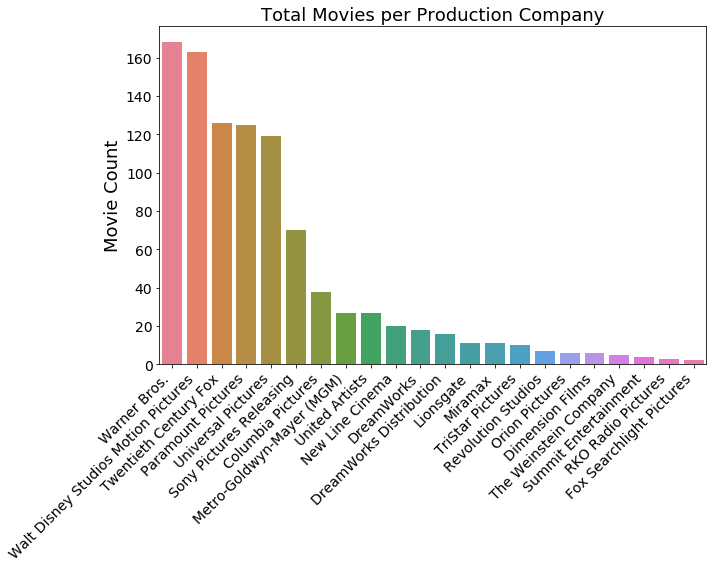

In [37]:
prod_comp_df = movie_df.copy()
prod_comp_df.loc[movie_df['production_companies'] != 'None']
prod_comp_series = (pd.DataFrame(prod_comp_df['production_companies'].value_counts())) \
    .reset_index()
prod_comp_series = prod_comp_series.rename(columns = {'index': 'production_company', \
    'production_companies': 'num_movies'})
prod_comp_plus_one_movie = prod_comp_series.loc[prod_comp_series['num_movies']>1]
prod_comp_plus_one_movie

bar_graph_function(prod_comp_plus_one_movie['production_company'], \
    prod_comp_plus_one_movie['num_movies'], 'Total Movies per Production Company', \
    '', 'Movie Count')

plt.savefig('images/prod_comp_movie_count.png')

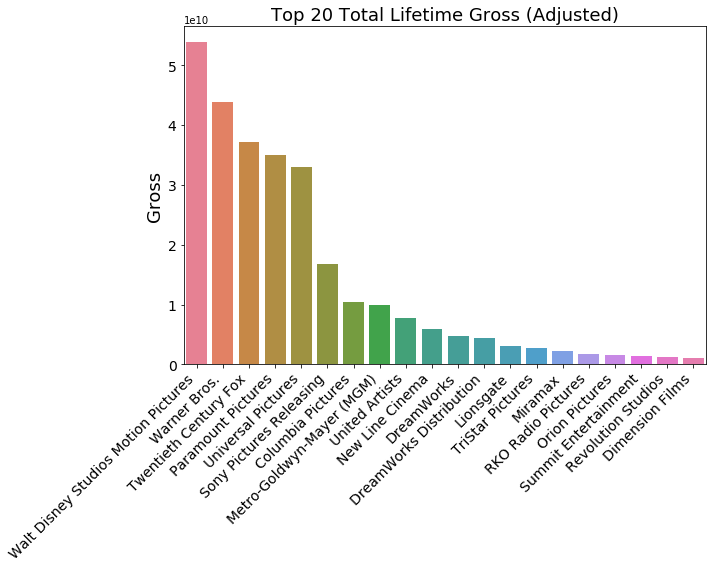

In [38]:
top_sum_grossing_prod_comp = (pd.DataFrame(prod_comp_df.groupby('production_companies') \
    ['adj_lifetime_gross'].sum().sort_values(ascending = False)).head(20)).reset_index()

bar_graph_function(top_sum_grossing_prod_comp['production_companies'], \
    top_sum_grossing_prod_comp['adj_lifetime_gross'], \
    'Top 20 Total Lifetime Gross (Adjusted)', '', 'Gross')

plt.savefig('images/prod_comp_total_gross.png')

In [39]:
prod_comp_series
prod_comp_series_a_b_df = prod_comp_series.copy()

prod_comp_series_a_b_df.loc[prod_comp_series_a_b_df['num_movies'] >= 100, 'a_b_list'] \
    = 'a_list'
prod_comp_series_a_b_df.loc[prod_comp_series_a_b_df['num_movies'] < 100, 'a_b_list'] = \
    'b_list'

prod_comp_series_a_b_df.drop('production_company', axis = 1)

alist_prod_comp = prod_comp_series.loc[prod_comp_series['num_movies'] >= 100]
blist_prod_comp = prod_comp_series.loc[prod_comp_series['num_movies'] < 100]

alist_prod_comp_list = list(alist_prod_comp['production_company'])

movie_df.reset_index(inplace = True)

for i in range(len(movie_df)): 
    prod_comp_ = movie_df.loc[i, "production_companies"]
    movie_df.loc[i,'a_list_production_comp'] = \
        (any(prod_comp_ in x for x in alist_prod_comp_list))*1



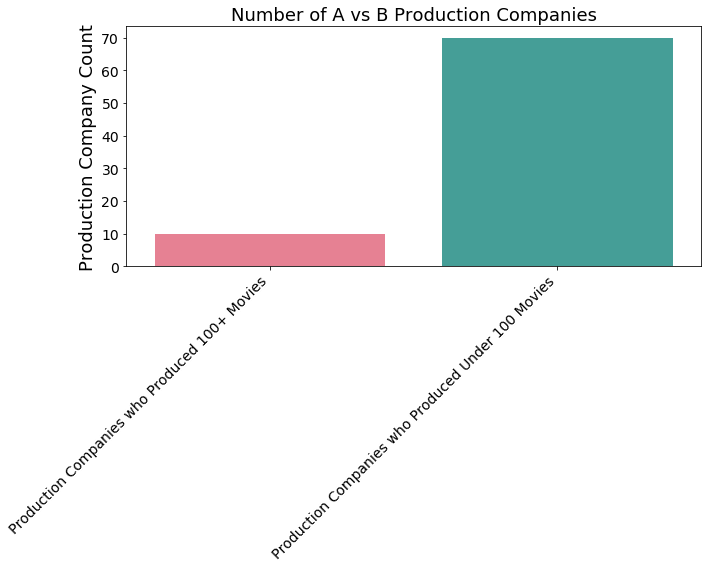

In [40]:
prod_comp_breakdown = [alist_prod_comp.size, blist_prod_comp.size]
prod_comp_x_labels = ['Production Companies who Produced 100+ Movies', \
                      'Production Companies who Produced Under 100 Movies']

bar_graph_function(prod_comp_x_labels, prod_comp_breakdown, \
                   'Number of A vs B Production Companies', \
                   '', 'Production Company Count')


In [41]:
# movie_df.reset_index(inplace = True)

### convert release date to three columns, release day, release month, and release year. Visualize these columns by plotting average gross

In [42]:
movie_df['release_day'] = (movie_df['earliest_dom_release_date'].dt.day)
movie_df['release_month'] = (movie_df['earliest_dom_release_date'].dt.month)
movie_df['release_year'] = (movie_df['earliest_dom_release_date'].dt.year)


In [43]:
release_date_df = (movie_df[['adj_lifetime_gross', 'release_day', 'release_month', \
                             'release_year']]).copy()
release_date_df.head()

,adj_lifetime_gross,release_day,release_month,release_year
0,279478053.0,5,10,1979
1,285296823.0,27,11,1996
2,159227221.0,25,12,2019
3,197585190.0,5,6,2003
4,409839115.0,3,4,1968


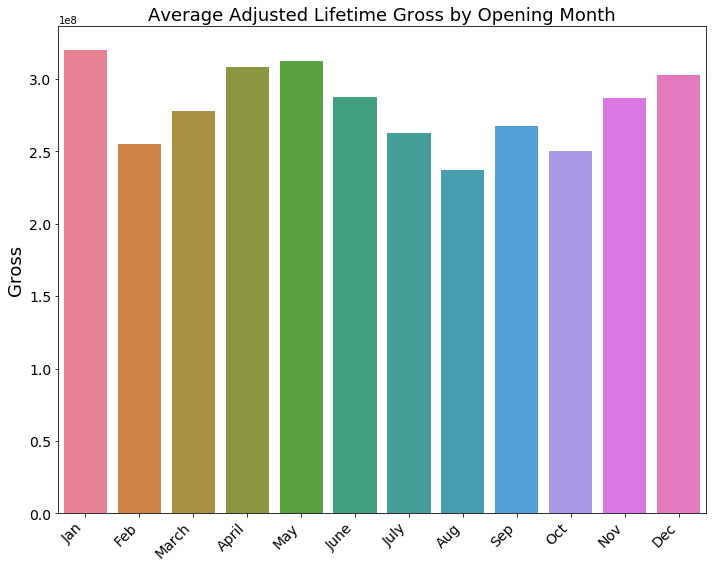

In [44]:

monthly_gross = pd.DataFrame(release_date_df.groupby('release_month') \
                             ['adj_lifetime_gross'].mean())
monthly_gross.reset_index(inplace = True)
month_list = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sep', \
              'Oct', 'Nov', 'Dec']
bar_graph_function(month_list, monthly_gross['adj_lifetime_gross'], \
                   'Average Adjusted Lifetime Gross by Opening Month', '', 'Gross')



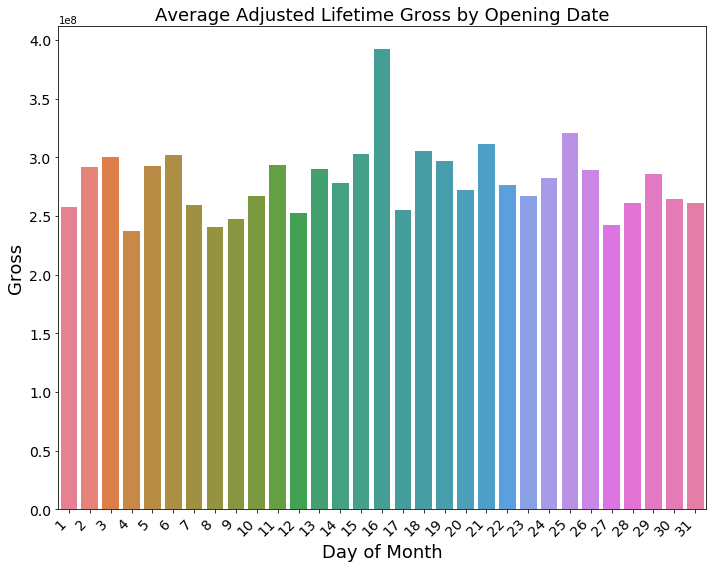

In [45]:

day_gross = pd.DataFrame(release_date_df.groupby('release_day') \
                         ['adj_lifetime_gross'].mean())
day_gross.reset_index(inplace = True)
bar_graph_function(day_gross['release_day'], day_gross['adj_lifetime_gross'], \
                   'Average Adjusted Lifetime Gross by Opening Date', \
                   'Day of Month', 'Gross')


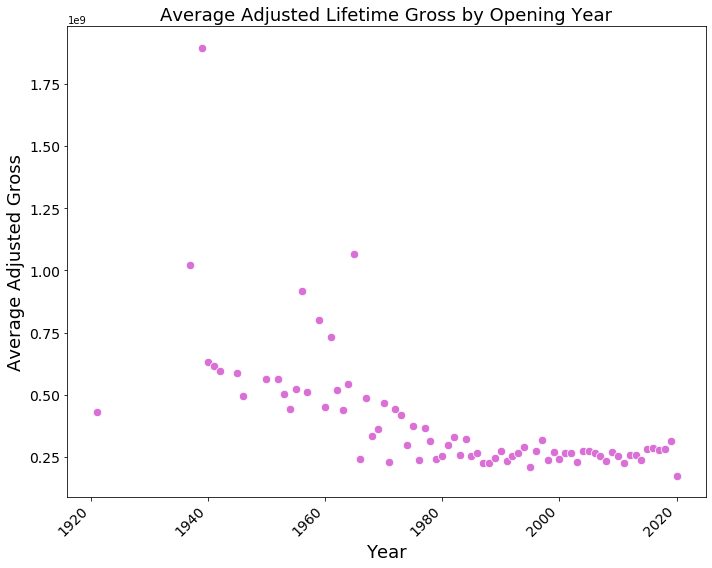

In [46]:
year_gross = pd.DataFrame(release_date_df.groupby('release_year') \
                          ['adj_lifetime_gross'].mean())
year_gross.reset_index(inplace = True)

scatter_function(year_gross['release_year'], year_gross['adj_lifetime_gross'], \
                 'Average Adjusted Lifetime Gross by Opening Year', 'Year', \
                 'Average Adjusted Gross')

plt.savefig('images/avg_gross_by_yr.png')

### convert the run time object datatype to a float datatype by removing 'hr' and 'min' strings and converting to total minutes

In [47]:
for i in range(len(movie_df)): 
    hour_substring = "hr"
    min_substring = "min"
    run_time = str(movie_df.loc[i, "running_time"])
    if hour_substring in run_time:
        run_time_edit_1 = run_time.replace("hr", "*60")
        if min_substring in run_time_edit_1:
            run_time_edit_2 = run_time_edit_1.replace("min", "")
            run_time_edit_3 = run_time_edit_2.replace("*60", "*60+")
            movie_df.loc[i, 'float_run_time'] = run_time_edit_3
        else:
            movie_df.loc[i, 'float_run_time'] = run_time_edit_1
    else:
        run_time_edit_4 = run_time.replace("min", "")
        movie_df.loc[i, 'float_run_time'] = run_time_edit_4


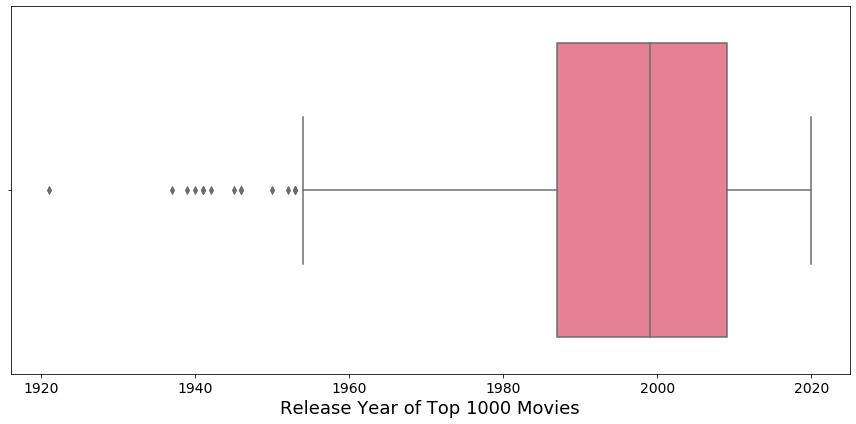

In [48]:
single_boxplot_function(movie_df['release_year'], 'Release Year of Top 1000 Movies')

In [49]:
for i in range(len(movie_df)):
    movie_df.loc[i, 'final_run_time'] = eval(movie_df.loc[i, 'float_run_time'])


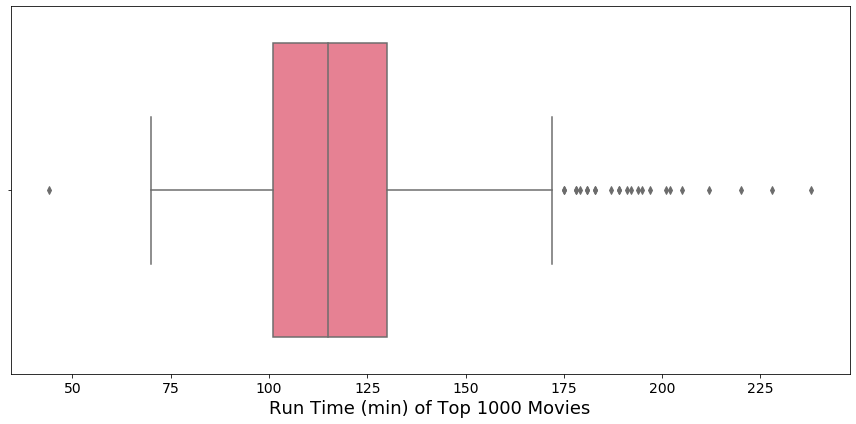

In [50]:
single_boxplot_function(movie_df['final_run_time'], 'Run Time (min) of Top 1000 Movies')

### visualize the top and worst performing movies according to return on investment

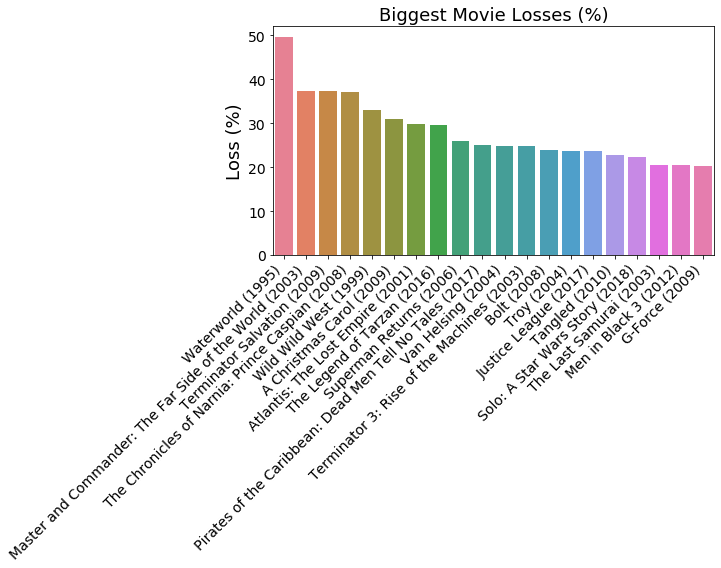

In [51]:
# movies_with_budget.reset_index(inplace = True)

biggest_movie_losses = movies_with_budget.nsmallest(20, 'return_on_investment')
biggest_movie_losses['return_on_investment'] = biggest_movie_losses['return_on_investment'] \
    *(-1)
bar_graph_function(biggest_movie_losses['movie_name'], \
    biggest_movie_losses['return_on_investment'], 'Biggest Movie Losses (%)', \
    '', 'Loss (%)')



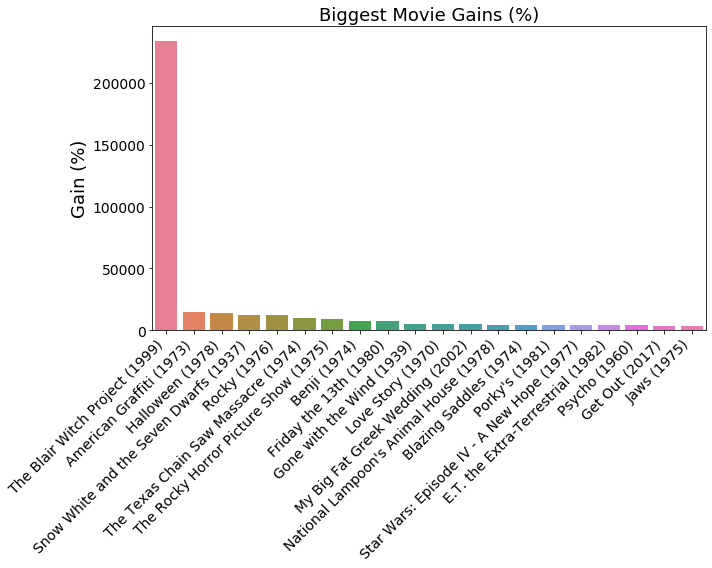

In [52]:
biggest_movie_gains = movies_with_budget.nlargest(20, 'return_on_investment')

bar_graph_function(biggest_movie_gains['movie_name'], \
    biggest_movie_gains['return_on_investment'], 'Biggest Movie Gains (%)', \
    '', 'Gain (%)')



### export the final dataframe to a csv for modeling within 'capstoneModelRegressors.ipynb'

In [53]:
movie_df.to_csv('capstone_df', index = False)

movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 64 columns):
movie_name                   1000 non-null object
movie_name_no_year           1000 non-null object
adj_lifetime_gross           1000 non-null float64
lifetime_gross               1000 non-null float64
est_num_tickets              1000 non-null float64
mpaa_rating                  1000 non-null object
running_time                 1000 non-null object
earliest_dom_release_date    1000 non-null datetime64[ns]
production_companies         1000 non-null object
movie_genre                  1000 non-null object
cast                         1000 non-null object
director                     1000 non-null object
writer                       1000 non-null object
producer                     1000 non-null object
composer                     1000 non-null object
cinematographer              1000 non-null object
prod_designer                1000 non-null object
editor                       1000